# Global probing performance by triplet count

This notebook plots the non-CLS global probe results by triplet count. The y-axis uses the false positive rate reported in `probe_results.json`, which is already normalized by the number of absent pairs in each group (mean over absent labels).

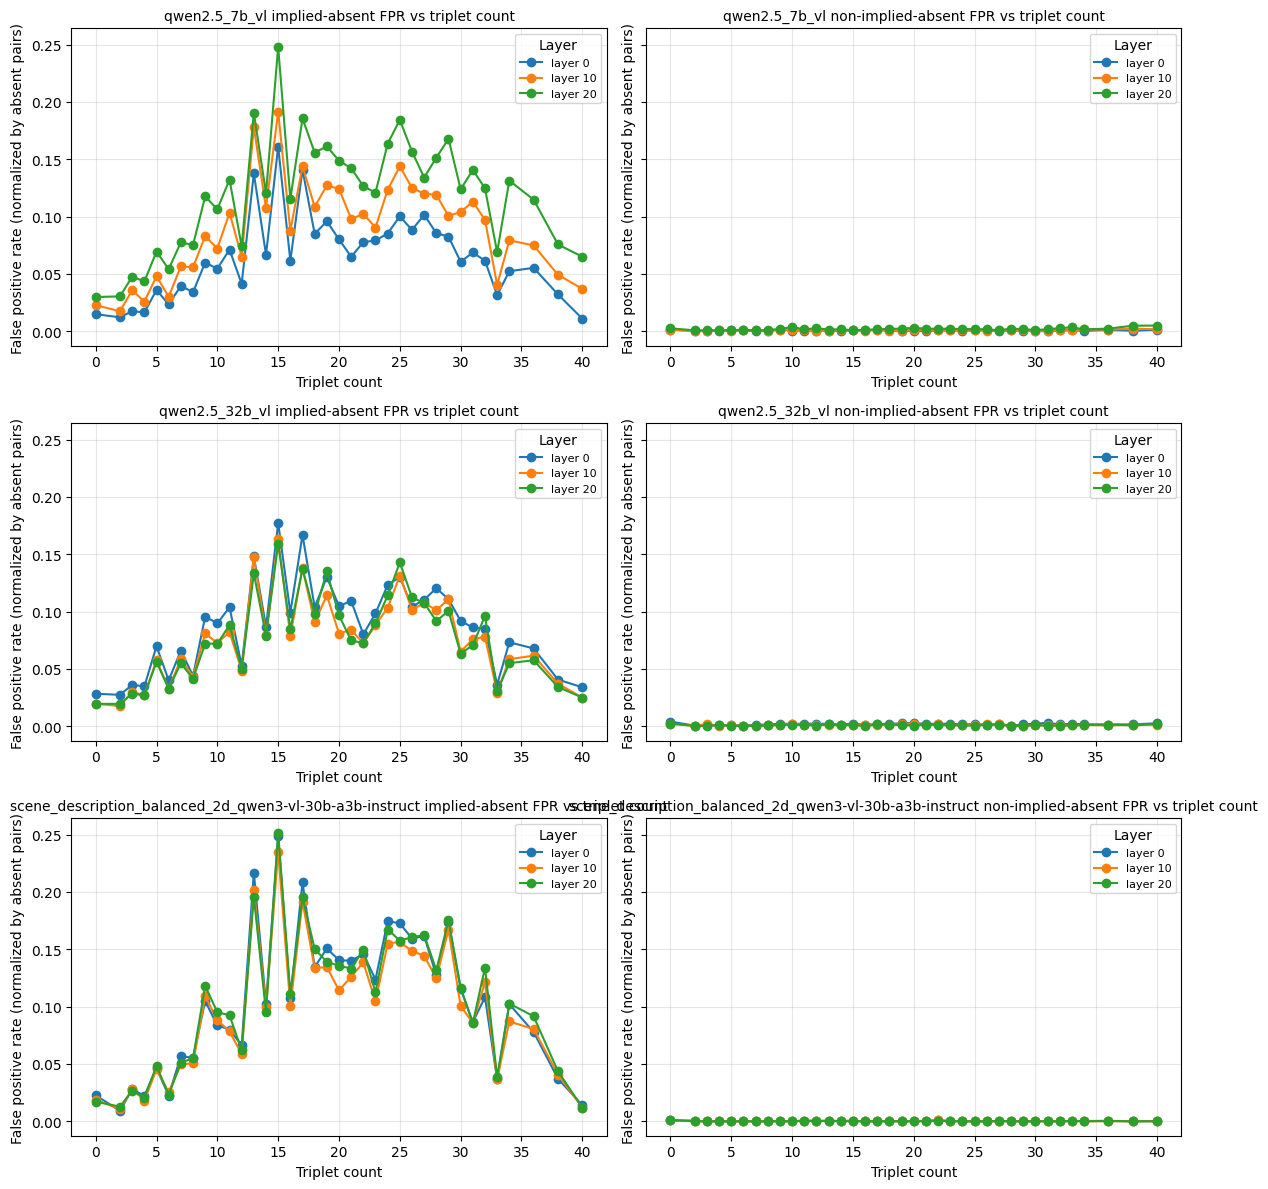

In [4]:
import json
import math
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

RESULTS_PATHS = [
    Path("../output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes/probe_results_per_sample.json"),
    Path("../output/probing_global/scene_description_balanced_2d_qwen2.5-VL-32B-Instruct/probes/probe_results_per_sample.json"),
    Path("../output/probing_global/scene_description_balanced_2d_qwen3-vl-30b-a3b-instruct/probes/probe_results_per_sample.json"),
]

USE_STAR_MARKERS = False

MODEL_NAME_MAP = {
    "scene_description_balanced_2d_qwen2.5-VL-7B-Instruct": "qwen2.5_7b_vl",
    "scene_description_balanced_2d_qwen2.5-VL-32B-Instruct": "qwen2.5_32b_vl",
}

TITLE_FONTSIZE = 10

for p in RESULTS_PATHS:
    if not p.exists():
        raise FileNotFoundError(f"Missing results file: {p}")

def _load_results(path: Path):
    raw = path.read_text()
    results = json.loads(raw, parse_constant=lambda x: float("nan"))
    non_cls_keys = [k for k in results.keys() if k.startswith("X_") and not k.startswith("X_cls_")]
    non_cls_keys = sorted(non_cls_keys, key=lambda k: int(k.split("_", 1)[1]))
    return results, non_cls_keys

def _series_from_group(d):
    xs = []
    ys = []
    for k, v in d.items():
        x = int(k)
        y = float(v)
        if math.isnan(y):
            y = np.nan
        xs.append(x)
        ys.append(y)
    order = np.argsort(xs)
    xs = np.asarray(xs)[order]
    ys = np.asarray(ys)[order]
    return xs, ys

fig, axes = plt.subplots(len(RESULTS_PATHS), 2, figsize=(12, 4 * len(RESULTS_PATHS)), sharey=True)
if len(RESULTS_PATHS) == 1:
    axes = np.array([axes])

for row, path in enumerate(RESULTS_PATHS):
    results, non_cls_keys = _load_results(path)
    run_name = path.parents[1].name
    model_name = MODEL_NAME_MAP.get(run_name, run_name)

    for key in non_cls_keys:
        layer = int(key.split("_", 1)[1])
        implied = results[key]["implied_fpr_by_triplet"]
        non_implied = results[key]["non_implied_fpr_by_triplet"]

        x_i, y_i = _series_from_group(implied)
        x_n, y_n = _series_from_group(non_implied)

        marker_style = "*" if USE_STAR_MARKERS else "o"
        axes[row, 0].plot(x_i, y_i, marker=marker_style, linewidth=1.5, label=f"layer {layer}")
        axes[row, 1].plot(x_n, y_n, marker=marker_style, linewidth=1.5, label=f"layer {layer}")

    axes[row, 0].set_title(f"{model_name} implied-absent FPR vs triplet count", fontsize=TITLE_FONTSIZE)
    axes[row, 1].set_title(f"{model_name} non-implied-absent FPR vs triplet count", fontsize=TITLE_FONTSIZE)
    for col in range(2):
        ax = axes[row, col]
        ax.set_xlabel("Triplet count")
        ax.set_ylabel("False positive rate (normalized by absent pairs)")
        ax.grid(True, alpha=0.3)
        ax.legend(title="Layer", fontsize=8)

plt.tight_layout()

out_dir = Path("analysis/plots")
out_dir.mkdir(parents=True, exist_ok=True)
base_name = "global_probe_fpr_by_triplet"
for ext in ("pdf", "png", "svg"):
    fig.savefig(out_dir / f"{base_name}.{ext}", bbox_inches="tight")

plt.show()


In [3]:
from pathlib import Path
import numpy as np
from sklearn.model_selection import train_test_split

EMBEDDINGS_PATHS = [
    Path("../output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/global_embeddings.npz"),
    Path("../output/probing_global/scene_description_balanced_2d_qwen2.5-VL-32B-Instruct/global_embeddings.npz"),
]

# Match training settings
TEST_SPLIT = 0.2
SEED = 0

for p in EMBEDDINGS_PATHS:
    if not p.exists():
        raise FileNotFoundError(f"Missing embeddings file: {p}")


In [2]:
def implied_pairs_by_triplet(embeddings_path: Path, test_split=0.2, seed=0):
    with np.load(embeddings_path) as z:
        triplet = z["triplet_count_per_sample"]
        implied = z["y_implied_absent"].astype(bool)

    idx = np.arange(len(triplet))
    idx_train, idx_test = train_test_split(
        idx,
        test_size=test_split,
        random_state=seed,
        stratify=triplet if len(np.unique(triplet)) > 1 else None,
    )

    triplet_test = triplet[idx_test]
    implied_test = implied[idx_test]

    triplet_vals = sorted(np.unique(triplet_test))
    n_pairs = []
    for t in triplet_vals:
        m = triplet_test == t
        n_pairs.append(int(implied_test[m].sum()))
    return np.array(triplet_vals), np.array(n_pairs)


NameError: name 'EMBEDDINGS_PATHS' is not defined

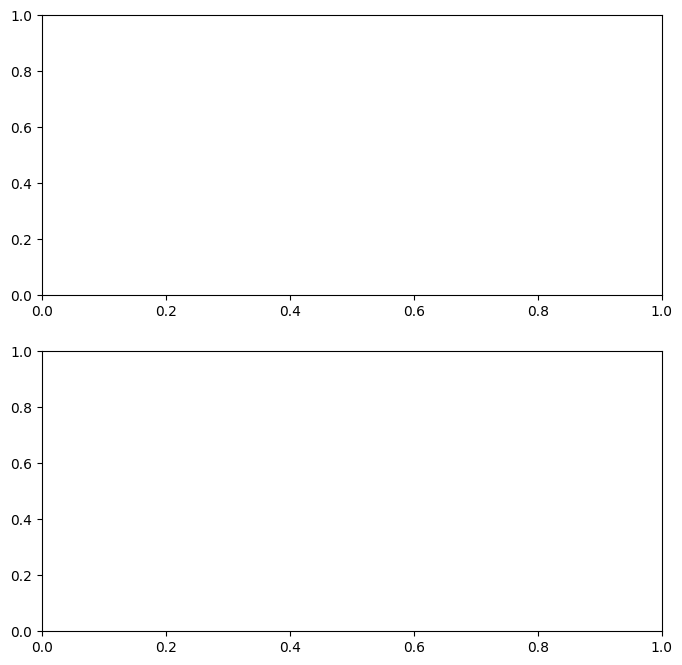

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Choose which layer key to inspect
FEATURE_KEY = "X_0"  # e.g., "X_0", "X_10", "X_20"

fig, axes = plt.subplots(len(RESULTS_PATHS), 1, figsize=(8, 4 * len(RESULTS_PATHS)))
if len(RESULTS_PATHS) == 1:
    axes = [axes]

for ax, results_path, emb_path in zip(axes, RESULTS_PATHS, EMBEDDINGS_PATHS):
    results, _ = _load_results(results_path)
    fpr_by_triplet = results[FEATURE_KEY]["implied_fpr_by_triplet"]

    triplet_vals = sorted(int(k) for k in fpr_by_triplet.keys())
    fpr_vals = np.array([float(fpr_by_triplet[str(k)]) for k in triplet_vals])

    t_pairs, n_pairs = implied_pairs_by_triplet(emb_path, TEST_SPLIT, SEED)

    # Align n_pairs to triplet_vals
    pair_map = {t: n for t, n in zip(t_pairs, n_pairs)}
    n_pairs_aligned = np.array([pair_map.get(t, 0) for t in triplet_vals])

    # Standard error approximation for a proportion
    se = np.array([
        np.sqrt(p * (1 - p) / n) if n > 0 else np.nan
        for p, n in zip(fpr_vals, n_pairs_aligned)
    ])

    # FPR with error bars
    ax.errorbar(triplet_vals, fpr_vals, yerr=se, fmt="o-", capsize=3, label="FPR (implied-absent)")

    # Secondary axis: number of implied-absent pairs
    ax2 = ax.twinx()
    ax2.plot(triplet_vals, n_pairs_aligned, "k--", alpha=0.6, label="# implied-absent pairs")

    run_name = results_path.parents[1].name
    model_name = MODEL_NAME_MAP.get(run_name, run_name)
    ax.set_title(f"{model_name} implied-absent FPR + N_pairs ({FEATURE_KEY})", fontsize=TITLE_FONTSIZE)
    ax.set_xlabel("Triplet count")
    ax.set_ylabel("FPR")
    ax.grid(True, alpha=0.3)
    ax2.set_ylabel("# implied-absent pairs")

    # Combined legend
    lines1, labels1 = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax.legend(lines1 + lines2, labels1 + labels2, fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()


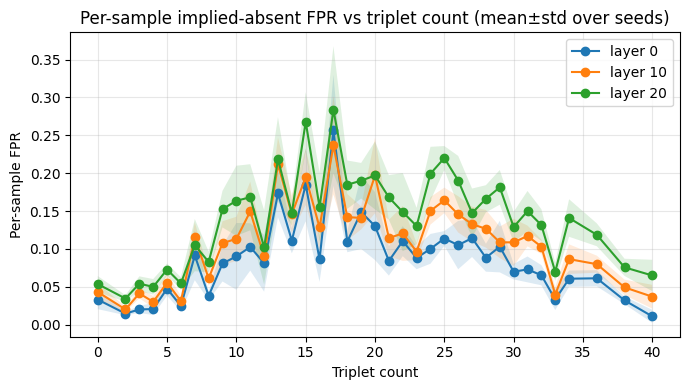

In [5]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import re

run_dir = Path("../output/probing_global/scene_description_balanced_2d_qwen2.5-VL-7B-Instruct/probes")
inter_dir = run_dir / "intermediates"

def per_sample_fpr_by_triplet(npz_path: Path):
    z = np.load(npz_path)
    triplet = z["triplet_count_per_sample"]
    y_pred = z["y_pred"].astype(bool)
    implied = z["y_implied_absent"].astype(bool)

    # per-sample FPR on implied-absent pairs
    fpr_s = np.full(triplet.shape[0], np.nan, dtype=float)
    for i in range(len(triplet)):
        m = implied[i]
        if m.any():
            fpr_s[i] = y_pred[i, m].mean()

    out = {}
    for t in np.unique(triplet):
        mask_t = triplet == t
        vals = fpr_s[mask_t]
        vals = vals[np.isfinite(vals)]
        out[int(t)] = float(vals.mean()) if len(vals) else np.nan
    return out

# Load all layers/seeds in this run
files = sorted(inter_dir.glob("X_*_seed*.npz"))

series = {}  # layer -> (xs, ys)
for f in files:
    m = re.match(r"(X_\d+)_seed(\d+)\.npz$", f.name)
    if not m:
        continue
    feat = m.group(1)               # e.g. X_0
    layer = int(feat.split("_")[1]) # 0, 10, 20
    d = per_sample_fpr_by_triplet(f)
    xs = np.array(sorted(d.keys()))
    ys = np.array([d[x] for x in xs])
    series.setdefault(layer, []).append((xs, ys))

# Average across seeds (aligning on xs)
avg_series = {}
for layer, seed_series in series.items():
    all_x = sorted(set(np.concatenate([xs for xs, _ in seed_series])))
    mat = []
    for xs, ys in seed_series:
        mp = {int(x): float(y) for x, y in zip(xs, ys)}
        mat.append([mp.get(x, np.nan) for x in all_x])
    mat = np.array(mat, dtype=float)
    avg = np.nanmean(mat, axis=0)
    std = np.nanstd(mat, axis=0)
    avg_series[layer] = (np.array(all_x), avg, std)

plt.figure(figsize=(7,4))
for layer in sorted(avg_series):
    xs, avg, std = avg_series[layer]
    plt.plot(xs, avg, marker="o", label=f"layer {layer}")
    plt.fill_between(xs, avg-std, avg+std, alpha=0.15)
plt.title("Per-sample implied-absent FPR vs triplet count (mean±std over seeds)")
plt.xlabel("Triplet count")
plt.ylabel("Per-sample FPR")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()
